In [1]:
import os
import sys
import pandas as pd
from datetime import datetime, timedelta
import hashlib

In [2]:
sys.path.append('../')
sys.path.append('../src/')
sys.path.append('../spell/')

In [3]:
import EncodeCommand

In [4]:
normal = pd.read_csv('../cleaned_data/normal.csv')
anomalous = pd.read_csv('../cleaned_data/anomalous0.csv')
silent = pd.read_csv('../cleaned_data/silent.log.csv')

In [5]:
normal.head()

,cwd,exit,items,ppid,pid,comm,timedelta,id_anomalies,num_id_anomalies
0,/g100/home/userexternal/cmatteuc/Nek5000/run/f...,0.0,2.0,29378.0,37632.0,squeue,NaN,0,0
1,/var/lib/pacemaker/cores,0.0,3.0,3532.0,37633.0,ping,1.862,0,8
2,NaN,NaN,NaN,NaN,NaN,NaN,0.002,0,0
3,NaN,NaN,NaN,NaN,NaN,NaN,0.006,0,0
4,NaN,NaN,NaN,NaN,NaN,NaN,0.001,0,0


In [6]:
anomalous.head()

,cwd,exit,items,ppid,pid,comm,timedelta,pid_timedelta,id_anomalies,num_id_anomalies,ARGV_PROCTITLE_str
0,/home/matteo/Desktop/priv_esc_scripts/linpeas,-2,1,28988,29144,find,NaN,NaN,0,0,find / -type f -iname .* ! -path /sys/* ! -pat...
1,/home/matteo/Desktop/priv_esc_scripts/linpeas,-2,1,28988,29144,find,0.0,0 days 00:00:00,0,0,find / -type f -iname .* ! -path /sys/* ! -pat...
2,/home/matteo/Desktop/priv_esc_scripts/linpeas,-2,1,28988,29144,find,0.0,0 days 00:00:00,0,0,find / -type f -iname .* ! -path /sys/* ! -pat...
3,/home/matteo/Desktop/priv_esc_scripts/linpeas,-2,1,28988,29144,find,0.0,0 days 00:00:00,0,0,find / -type f -iname .* ! -path /sys/* ! -pat...
4,/home/matteo/Desktop/priv_esc_scripts/linpeas,-2,1,28988,29144,find,0.0,0 days 00:00:00,0,0,find / -type f -iname .* ! -path /sys/* ! -pat...


In [7]:
silent.head()

,cwd,exit,items,ppid,pid,comm,timedelta,id_anomalies,num_id_anomalies
0,/home/matteo/Desktop/priv_esc_scripts/linpeas,0.0,2.0,12265.0,12763.0,sed,NaN,0.0,0
1,/home/matteo/Desktop/priv_esc_scripts/linpeas,0.0,2.0,12265.0,12766.0,sed,0.007,0.0,0
2,/home/matteo/Desktop/priv_esc_scripts/linpeas,0.0,2.0,12265.0,12767.0,sed,0.019,0.0,0
3,/home/matteo/Desktop/priv_esc_scripts/linpeas,0.0,2.0,12265.0,12764.0,sed,-0.025,0.0,0
4,/home/matteo/Desktop/priv_esc_scripts/linpeas,0.0,2.0,12265.0,12765.0,sed,0.052,0.0,0


In [8]:
normal.columns

Index(['cwd', 'exit', 'items', 'ppid', 'pid', 'comm', 'timedelta',
       'id_anomalies', 'num_id_anomalies'],
      dtype='object')

In [9]:
anomalous.columns

Index(['cwd', 'exit', 'items', 'ppid', 'pid', 'comm', 'timedelta',
       'pid_timedelta', 'id_anomalies', 'num_id_anomalies',
       'ARGV_PROCTITLE_str'],
      dtype='object')

In [10]:
silent.columns

Index(['cwd', 'exit', 'items', 'ppid', 'pid', 'comm', 'timedelta',
       'id_anomalies', 'num_id_anomalies'],
      dtype='object')

## Preprocessing

In [11]:
def count_directories(path):
    try:
        # Split the path into components
        components = path.split(os.sep)
        # Filter out empty components (which can occur if the path starts with a separator)
        directories = [comp for comp in components if comp]
    except:
        directories = []
    return len(directories)

In [12]:
def string_to_milliseconds(time_str):
    try:
        # Step 1: Parse the string into days and time component
        time_parts = time_str.split(' days ')
        days = int(time_parts[0])
        time_component = time_parts[1]
        
        # Step 2: Split the time component into hours, minutes, seconds, and microseconds
        hours, minutes, seconds = map(float, time_component.replace(':', ' ').split())
        
        # Step 3: Create a timedelta object
        time_delta = timedelta(
            days=days,
            hours=int(hours),
            minutes=int(minutes),
            seconds=int(seconds),
            microseconds=int((seconds - int(seconds)) * 1_000_000)
        )
        
        # Step 4: Convert the timedelta object to milliseconds
        milliseconds = time_delta.total_seconds() * 1000
    except:
        milliseconds = 0
    return abs(milliseconds)

In [13]:
def encode_pid_to_8bit_binary_hash(pid):
    """
    Encode a PID (Process ID) using SHA-256 hash and return an 8-bit binary string.

    Parameters:
    pid (int): The process ID to encode.

    Returns:
    str: An 8-bit binary representation of the hash of the PID.
    """
    # Convert the PID to a string and then to bytes
    pid_bytes = str(pid).encode('utf-8')
    
    # Compute the SHA-256 hash of the PID
    hash_object = hashlib.sha256(pid_bytes)
    
    # Get the hash as a hexadecimal string
    hash_hex = hash_object.hexdigest()
    
    # Convert the first byte (2 hex digits) of the hash to an integer
    first_byte = int(hash_hex[:2], 16)
    
    # Convert the integer to an 8-bit binary string
    binary_hash = format(first_byte, '08b')

    # final int
    r = int(binary_hash,2)
    
    return float(r/256)

In [16]:
def preprocess(df, encoder):
    
    # Select only common columns
    cols = ['cwd', 'exit', 'items', 'ppid', 'pid', 'comm', 'timedelta','id_anomalies', 'num_id_anomalies']
    df = df[cols]

    # convert times to numbers
    try:
        df['pid_timedelta_ms'] = df['pid_timedelta'].apply(string_to_milliseconds)
        df = df.drop('pid_timedelta', axis=1)
    except:
        pass
    
    # Fill NaN values with 0
    df = df.fillna(0)
    
    # preprocess cwd column by extracting path length
    df['fp_length'] = df['cwd'].apply(count_directories)
    df = df.drop('cwd', axis=1)

    # encode the command
    df = encoder.encode_command(df)
    df = df.drop('comm', axis=1)

    # encode the pids
    df['pid'] = df['pid'].apply(encode_pid_to_8bit_binary_hash)
    df['ppid'] = df['ppid'].apply(encode_pid_to_8bit_binary_hash)
    

    # convert all df to floats
    df = df.astype(float)
    
    return df
    

In [18]:
encoder = EncodeCommand.EncodeCommand()
normal_ = preprocess(normal,encoder)
anomalous_ = preprocess(anomalous, encoder)
silent_ = preprocess(silent, encoder)

In [19]:
normal_.head()

,exit,items,ppid,pid,timedelta,id_anomalies,num_id_anomalies,fp_length,enc_comm
0,0.0,2.0,0.781250,0.230469,0.000,0.0,0.0,7.0,1.0
1,0.0,3.0,0.636719,0.417969,1.862,0.0,8.0,4.0,2.0
2,0.0,0.0,0.539062,0.539062,0.002,0.0,0.0,0.0,3.0
3,0.0,0.0,0.539062,0.539062,0.006,0.0,0.0,0.0,3.0
4,0.0,0.0,0.539062,0.539062,0.001,0.0,0.0,0.0,3.0


In [20]:
anomalous_.head()

,exit,items,ppid,pid,timedelta,id_anomalies,num_id_anomalies,fp_length,enc_comm
0,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,5.0,54.0
1,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,5.0,54.0
2,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,5.0,54.0
3,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,5.0,54.0
4,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,5.0,54.0


In [21]:
silent_.head()

,exit,items,ppid,pid,timedelta,id_anomalies,num_id_anomalies,fp_length,enc_comm
0,0.0,2.0,0.449219,0.164062,0.000,0.0,0.0,5.0,1.0
1,0.0,2.0,0.449219,0.281250,0.007,0.0,0.0,5.0,1.0
2,0.0,2.0,0.449219,0.089844,0.019,0.0,0.0,5.0,1.0
3,0.0,2.0,0.449219,0.210938,-0.025,0.0,0.0,5.0,1.0
4,0.0,2.0,0.449219,0.335938,0.052,0.0,0.0,5.0,1.0


## an det

In [22]:
import DeepLearningAnomalyDetection2

2024-09-06 07:57:58.468838: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-06 07:57:58.524102: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 07:57:59.378547: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Mean normal reconstruction error: 0.008975211189586739
Mean anomalous reconstruction error: 0.04340112562525675


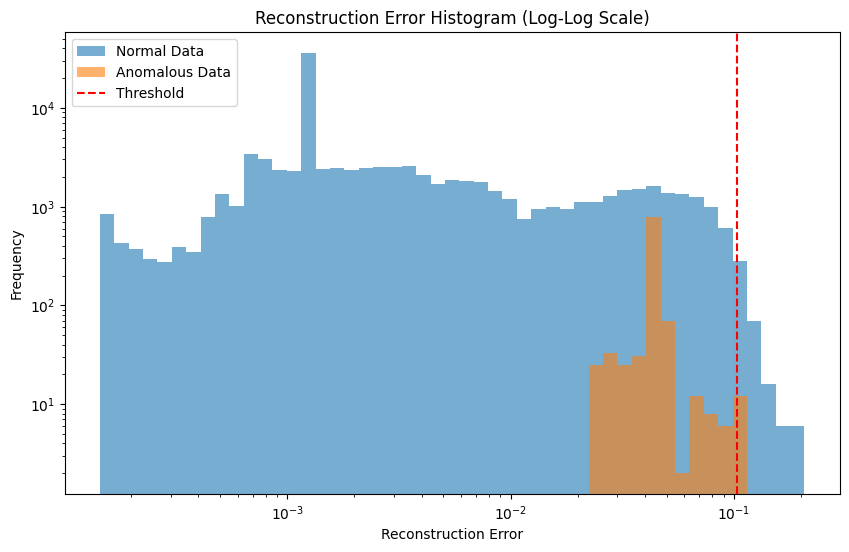

Threshold for anomaly detection: 0.10380934433909723
Number of anomalies detected: 0
Number of false positives detected: 250


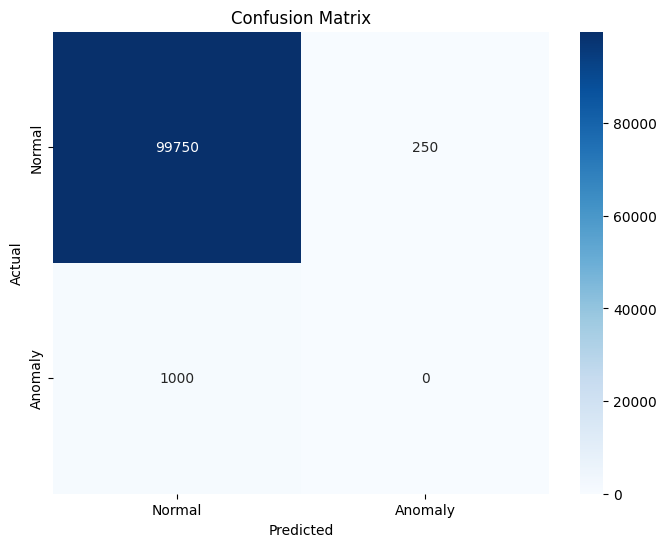

In [23]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(normal_, anomalous_, 'autoencoder', laurel=1, plots=[0,0,1,1])

Mean normal reconstruction error: 0.00385248843565601
Mean anomalous reconstruction error: 227551.7782091279


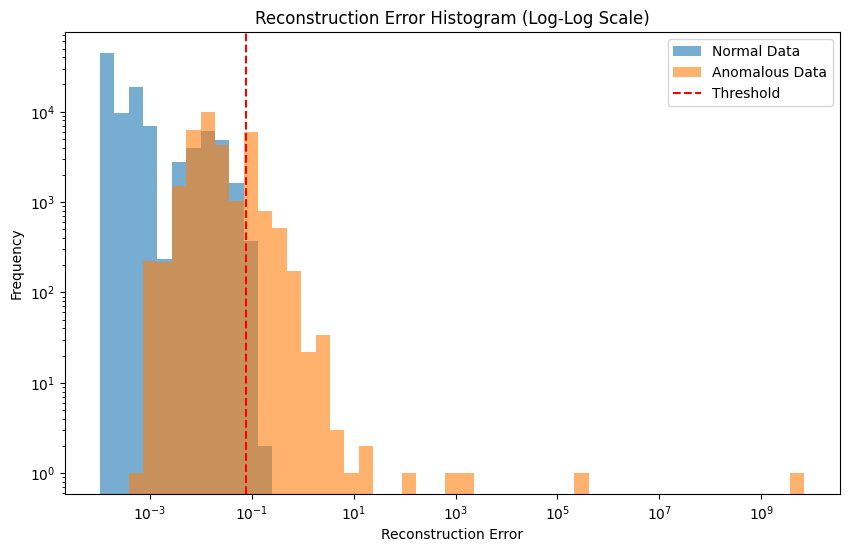

Threshold for anomaly detection: 0.0784613111231153
Number of anomalies detected: 7422
Number of false positives detected: 250


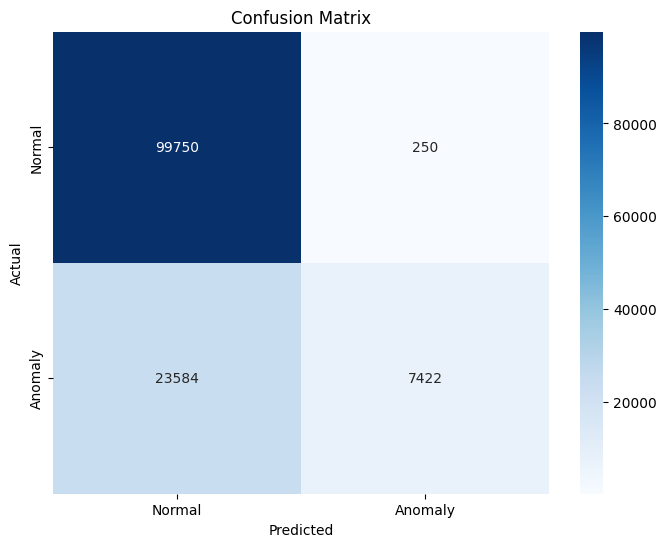

In [24]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(normal_, silent_, 'autoencoder', laurel=1, plots=[0,0,1,1])

In [27]:
# remove features
normal_small = normal_.drop(['pid', 'ppid'], axis=1)
silent_small = silent_.drop(['pid', 'ppid'], axis=1)

In [28]:
normal_small.head()

,exit,items,timedelta,id_anomalies,num_id_anomalies,fp_length,enc_comm
0,0.0,2.0,0.000,0.0,0.0,7.0,1.0
1,0.0,3.0,1.862,0.0,8.0,4.0,2.0
2,0.0,0.0,0.002,0.0,0.0,0.0,3.0
3,0.0,0.0,0.006,0.0,0.0,0.0,3.0
4,0.0,0.0,0.001,0.0,0.0,0.0,3.0


In [29]:
silent_small.head()

,exit,items,timedelta,id_anomalies,num_id_anomalies,fp_length,enc_comm
0,0.0,2.0,0.000,0.0,0.0,5.0,1.0
1,0.0,2.0,0.007,0.0,0.0,5.0,1.0
2,0.0,2.0,0.019,0.0,0.0,5.0,1.0
3,0.0,2.0,-0.025,0.0,0.0,5.0,1.0
4,0.0,2.0,0.052,0.0,0.0,5.0,1.0


Mean normal reconstruction error: 0.0007179368711556327
Mean anomalous reconstruction error: 292564.2052183946


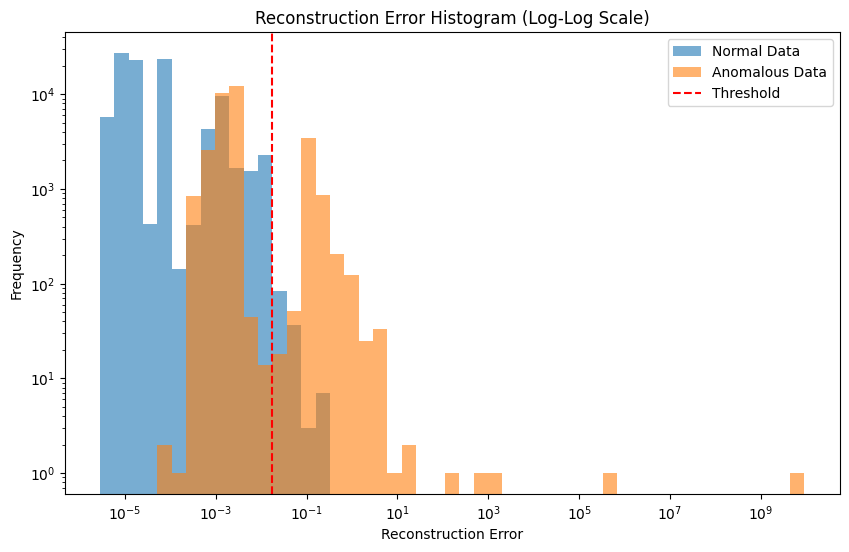

Threshold for anomaly detection: 0.017261564929437975
Number of anomalies detected: 4795
Number of false positives detected: 146


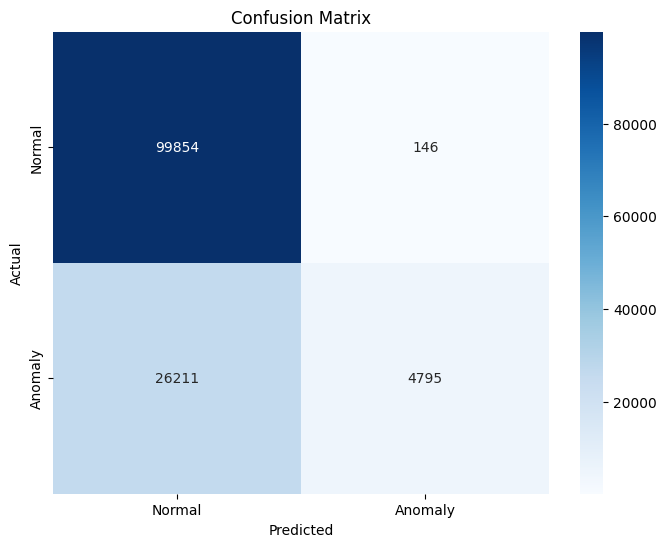

In [30]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(normal_small, silent_small, 'autoencoder', laurel=1, plots=[0,0,1,1])

## seq methods

In [25]:
normal_.head()

,exit,items,ppid,pid,timedelta,id_anomalies,num_id_anomalies,fp_length,enc_comm
0,0.0,2.0,0.781250,0.230469,0.000,0.0,0.0,7.0,1.0
1,0.0,3.0,0.636719,0.417969,1.862,0.0,8.0,4.0,2.0
2,0.0,0.0,0.539062,0.539062,0.002,0.0,0.0,0.0,3.0
3,0.0,0.0,0.539062,0.539062,0.006,0.0,0.0,0.0,3.0
4,0.0,0.0,0.539062,0.539062,0.001,0.0,0.0,0.0,3.0


In [26]:
silent_.head()

,exit,items,ppid,pid,timedelta,id_anomalies,num_id_anomalies,fp_length,enc_comm
0,0.0,2.0,0.449219,0.164062,0.000,0.0,0.0,5.0,1.0
1,0.0,2.0,0.449219,0.281250,0.007,0.0,0.0,5.0,1.0
2,0.0,2.0,0.449219,0.089844,0.019,0.0,0.0,5.0,1.0
3,0.0,2.0,0.449219,0.210938,-0.025,0.0,0.0,5.0,1.0
4,0.0,2.0,0.449219,0.335938,0.052,0.0,0.0,5.0,1.0


In [31]:
normal_.shape, silent_.shape

((100000, 9), (31006, 9))

In [44]:
int(normal_.shape[0]*0.2)

20000

In [45]:
# build train and test sets

# Define test size
test_size = int(normal_.shape[0]*0.2)

# Split the data into train and test sets
X_train_raw = normal_.iloc[:-test_size]  # All rows except the last `test_size` rows
X_test_raw = normal_.iloc[-test_size:]   # The last `test_size` rows

# Print the shapes to confirm the split
print("Train shape:", X_train_raw.shape)
print("Test shape:", X_test_raw.shape)

# Normalize both train and test sets using min-max normalization
X_min = X_train_raw.min()   # Minimum of each column
X_max = X_train_raw.max()   # Maximum of each column

# Normalize train and test sets using the training data min and max
X_train_raw = (X_train_raw - X_min) / (X_max - X_min)
X_test_raw = (X_test_raw - X_min) / (X_max - X_min)

Train shape: (80000, 9)
Test shape: (20000, 9)


In [62]:
import numpy as np
import pandas as pd

def build_sequences(df: pd.DataFrame, window=200, stride=20, telescope=10):
    """
    Creates sequences of data (features) and future data (as labels) from the given DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing the data.
    window (int): The size of the sliding window to capture sequences of data.
    stride (int): The number of rows to skip between windows.
    telescope (int): The number of rows into the future to use as the next sequence.
    
    Returns:
    tuple: Two numpy arrays containing the sequences (features) and corresponding future data (labels).
    """
    # Sanity check to avoid runtime errors
    assert window % stride == 0, "Window size must be divisible by the stride."
    
    dataset = []
    labels = []
    
    # Convert dataframe to numpy array
    temp_df = df.copy().values

    # Calculate if padding is needed
    padding_check = len(df) % window
    if padding_check != 0:
        # Compute padding length
        padding_len = window - padding_check
        # Pad the features with zeros to make the length divisible by the window size
        padding = np.zeros((padding_len, temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding, temp_df))
        assert len(temp_df) % window == 0

    # Iterate through the dataframe with the given stride
    for idx in np.arange(0, len(temp_df) - window - telescope, stride):
        # Extract the window of features
        dataset.append(temp_df[idx:idx + window])
        # Extract the label window after the current window
        labels.append(temp_df[idx + window:idx + window + telescope])

    # Convert to numpy arrays for easier handling
    dataset = np.array(dataset)
    labels = np.array(labels)
    
    return dataset, labels


In [63]:
X_train, y_train = build_sequences(X_train_raw)
X_test, y_test = build_sequences(X_test_raw)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3990, 200, 9), (3990, 10, 9), (990, 200, 9), (990, 10, 9))

In [68]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
input_shape, output_shape

((200, 9), (10, 9))

In [77]:
np.isnan(X_train[0]).any()
X_train = np.nan_to_num(X_train, nan=0.0)

True

In [78]:
X_train = np.nan_to_num(X_train, nan=0.0)
y_train = np.nan_to_num(y_train, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)
y_test = np.nan_to_num(y_test, nan=0.0)

In [79]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [80]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(input_shape, output_shape):
    """
    Builds an MLP model using TensorFlow/Keras that takes a 3D input and outputs a 3D output.
    
    Parameters:
    input_shape (tuple): Shape of the input data (e.g., (200, 9)).
    output_shape (tuple): Shape of the output data (e.g., (10, 9)).
    
    Returns:
    model (tf.keras.Model): Compiled MLP model.
    """
    model = models.Sequential()
    
    # Input Layer: Flatten input shape (200, 9) into (200*9,)
    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Flatten())  # Flatten the 3D input into a 1D vector (200 * 9 = 1800)

    # Hidden Layers (add more layers as necessary)
    model.add(layers.Dense(256, activation='relu'))  # 1st hidden layer with 256 neurons
    model.add(layers.Dense(128, activation='relu'))  # 2nd hidden layer with 128 neurons
    
    # Output Layer: Dense layer with output size matching output_shape (10*9 = 90)
    model.add(layers.Dense(output_shape[0] * output_shape[1], activation='linear'))  # Regression case
    
    # Reshape back to the original output shape (10, 9)
    model.add(layers.Reshape(output_shape))

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # MSE for regression
    
    return model

In [103]:
mlp = build_model(input_shape, output_shape)
mlp.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 1800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │       461,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 90)             │        11,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 10, 9)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 505,562 (1.93 MB)

 Trainable params: 505,562 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=50,         # Stop training if no improvement after 10 epochs
    restore_best_weights=True  # Restore the model weights from the epoch with the best loss
)

# Train the model and store the history
history = mlp.fit(
    X_train, y_train,            # Training data
    validation_split=0.2,        # Use 20% of the data for validation
    epochs=2000,                  # Maximum number of epochs to train
    batch_size=32,               # Batch size
    callbacks=[early_stopping],  # Early stopping callback
    verbose=1                    # Show progress
)

# Now, the `history` variable contains the training metrics, which you can plot later.

Epoch 1/2000
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0762 - mae: 0.1959 - val_loss: 0.0173 - val_mae: 0.0809
Epoch 2/2000
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0306 - mae: 0.1092 - val_loss: 0.0165 - val_mae: 0.0770
Epoch 3/2000
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0287 - mae: 0.1032 - val_loss: 0.0161 - val_mae: 0.0759
Epoch 4/2000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0276 - mae: 0.0997 - val_loss: 0.0158 - val_mae: 0.0739
Epoch 5/2000
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0268 - mae: 0.0971 - val_loss: 0.0157 - val_mae: 0.0742
Epoch 6/2000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263 - mae: 0.0957 - val_loss: 0.0155 - val_mae: 0.0725
Epoch 7/2000
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0257 - mae: 0.0944 - val_loss: 0.0151 - val_mae: 0.0691
Epoch 8/2000
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0252 - mae: 0.0932 - val_loss: 0.0148 - val_mae: 0.0664
Epoch 9/2000
100/100 ━━━━━━━━━━━━━━━━━━━

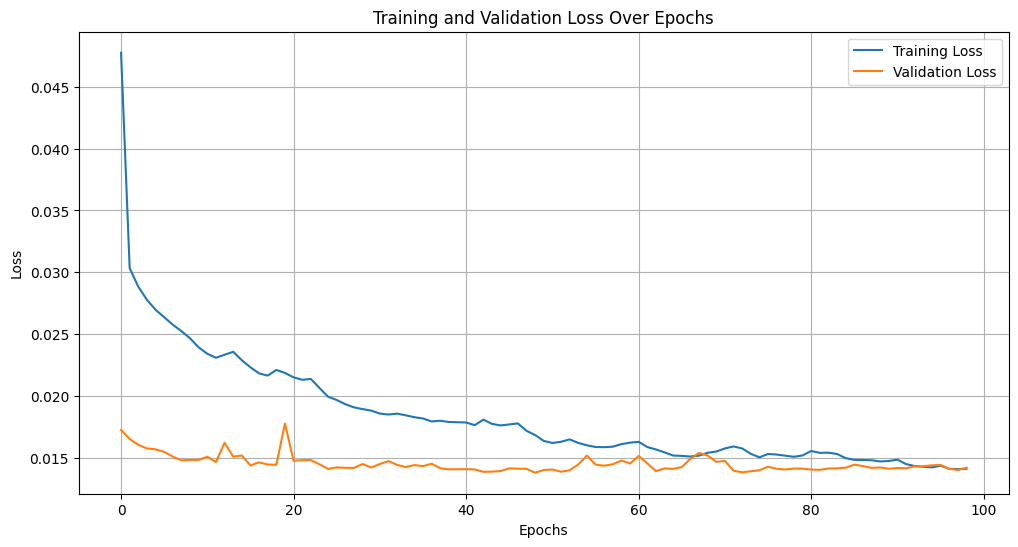

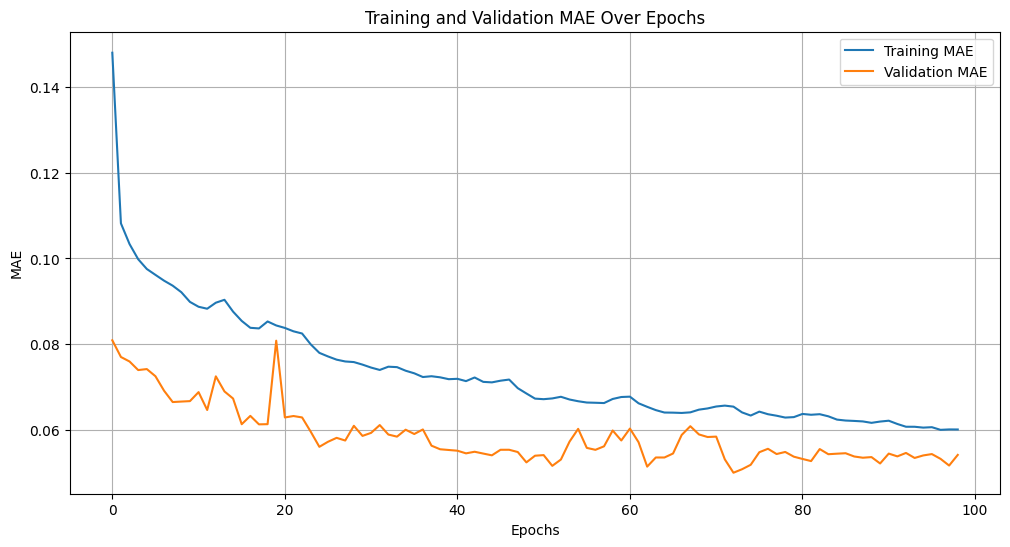

In [89]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# If you have other metrics, like MAE (mean absolute error), you can plot them too
if 'mae' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Training and Validation MAE Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.show()


In [94]:
# Assuming you have test data `X_test` and `y_test`
# Evaluate the model on the test set
test_loss, test_mae = mlp.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Make predictions on the test set
y_pred = mlp.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0248 - mae: 0.0772 
Test Loss: 0.035278160125017166
Test MAE: 0.10005731880664825
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [121]:
# now we test with anomalies
silent_max = silent_.max()
silent_min = silent_.min()

silent_ = (silent_ - silent_min) / (silent_max - silent_min)

X_silent, y_silent = build_sequences(silent_)

#X_silent = np.nan_to_num(X_silent, nan=0.0)
#y_silent = np.nan_to_num(y_silent, nan=0.0)

X_silent.shape, y_silent.shape

((1550, 200, 9), (1550, 10, 9))

In [124]:
# Assuming you have test data `X_test` and `y_test`
# Evaluate the model on the test set
test_loss, test_mae = mlp.evaluate(X_silent, y_silent)

print(f"Test Loss on silent dataset: {test_loss}")
print(f"Test MAE on silent dataset: {test_mae}")

# Make predictions on the test set
y_pred = mlp.predict(X_test)

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3700 - mae: 0.4687 
Test Loss on silent dataset: 0.37294822931289673
Test MAE on silent dataset: 0.47050780057907104
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## LSTM

In [110]:
# LSTM
import tensorflow as tf
from tensorflow.keras import layers, models

def build_lstm_model(input_shape, output_shape):
    """
    Builds an LSTM model using TensorFlow/Keras that takes a 3D input and outputs a 3D output.
    
    Parameters:
    input_shape (tuple): Shape of the input data (e.g., (200, 9)).
    output_shape (tuple): Shape of the output data (e.g., (10, 9)).
    
    Returns:
    model (tf.keras.Model): Compiled LSTM model.
    """
    model = models.Sequential()
    
    # Add LSTM layers
    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.LSTM(128, return_sequences=True))  # LSTM layer with 128 units
    model.add(layers.LSTM(64, return_sequences=True))   # LSTM layer with 64 units
    
    # Add Dense layer to produce the final output shape
    model.add(layers.TimeDistributed(layers.Dense(output_shape[1], activation='linear')))  # Dense layer with output_dim matching second dimension of output_shape

    model.add(layers.Lambda(lambda x: x[:, -output_shape[0]:, :]))
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # MSE for regression
    
    return model

In [111]:
lstm = build_lstm_model(input_shape, output_shape)
lstm.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 200, 128)       │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 200, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 200, 9)         │           585 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 10, 9)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,649 (471.29 KB)

 Trainable params: 120,649 (471.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 164ms/step - loss: 0.0539 - mae: 0.1448 - val_loss: 0.0148 - val_mae: 0.0615
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - loss: 0.0288 - mae: 0.0939 - val_loss: 0.0146 - val_mae: 0.0599
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - loss: 0.0285 - mae: 0.0923 - val_loss: 0.0147 - val_mae: 0.0604
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - loss: 0.0284 - mae: 0.0918 - val_loss: 0.0147 - val_mae: 0.0612
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - loss: 0.0283 - mae: 0.0912 - val_loss: 0.0147 - val_mae: 0.0608
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - loss: 0.0281 - mae: 0.0907 - val_loss: 0.0146 - val_mae: 0.0595
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - loss: 0.0280 - mae: 0.0903 - val_loss: 0.0145 - val_mae: 0.0585
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - loss: 0.0278 - mae: 0.0898 - val_loss: 0.0145 - val_mae: 0.0596
Epoch 9/100
100/100 ━━━━

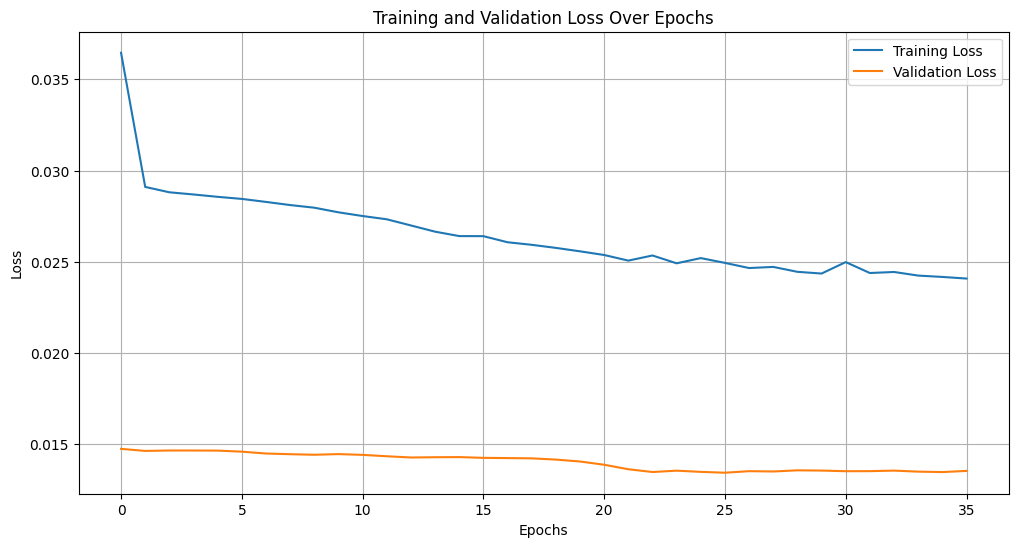

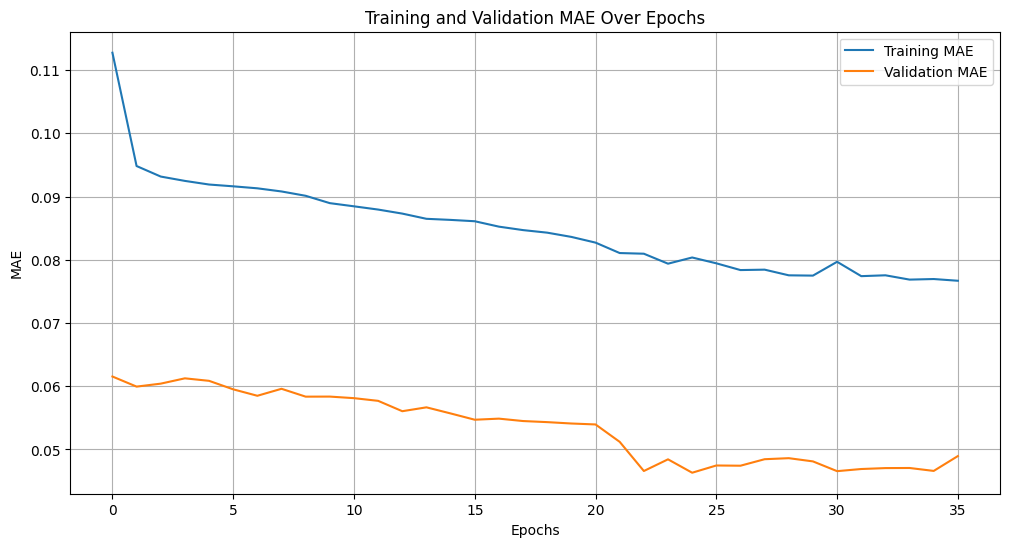

In [112]:
# Define model
model = lstm

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model and store the history
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation MAE if available
if 'mae' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Training and Validation MAE Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [125]:
# Assuming you have test data `X_test` and `y_test`
# Evaluate the model on the test set
an_test_loss, an_test_mae = model.evaluate(X_silent, y_silent)

print(f"Test Loss on silent dataset: {an_test_loss}")
print(f"Test MAE on silent dataset: {an_test_mae}")

# Make predictions on the test set
y_pred = model.predict(X_test)

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1030 - mae: 0.2498
Test Loss on silent dataset: 0.10253084450960159
Test MAE on silent dataset: 0.24972723424434662
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [ ]:
# Example error values (replace these with your actual error values)
final_training_error = history.history['loss'][-1]
final_validation_error = history.history['val_loss'][-1]
test_error = test_loss
anomalous_test_error = an_test_loss

# Labels and values
labels = ['Final Training Error', 'Final Validation Error', 'Test Error', 'Anomalous Test Error']
values = [final_training_error, final_validation_error, test_error, anomalous_test_error]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'green', 'orange', 'red'])

# Add labels and title
plt.xlabel('Error Type')
plt.ylabel('Error Value')
plt.title('Error Comparison')

# Show the plot
plt.show()

## transformer

In [134]:
# transformer
import tensorflow as tf
from tensorflow.keras import layers, models

def build_transformer_model(input_shape, output_shape, num_heads=4, ff_dim=128, num_blocks=2):
    """
    Builds a Transformer model using TensorFlow/Keras.
    
    Parameters:
    input_shape (tuple): Shape of the input data (e.g., (200, 9)).
    output_shape (tuple): Shape of the output data (e.g., (10, 9)).
    num_heads (int): Number of attention heads in MultiHeadAttention.
    ff_dim (int): Dimension of the feed-forward network.
    num_blocks (int): Number of Transformer blocks.
    
    Returns:
    model (tf.keras.Model): Compiled Transformer model.
    """
    inputs = layers.Input(shape=input_shape)
    
    # Positional Encoding
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    positions = tf.expand_dims(positions, 0)  # Shape: (1, seq_len)
    position_embeddings = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(positions)
    
    x = inputs + position_embeddings
    
    for _ in range(num_blocks):
        # Multi-Head Self-Attention
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=input_shape[1]
        )(x, x)
        attn_output = layers.Dropout(0.1)(attn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        # Feed Forward Network
        ff_output = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
        ff_output = layers.Conv1D(filters=input_shape[1], kernel_size=1)(ff_output)
        ff_output = layers.Dropout(0.1)(ff_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)
    
    # Dense Layer to produce the final output shape
    x = layers.TimeDistributed(layers.Dense(output_shape[1], activation='linear'))(x)

    x = layers.Lambda(lambda x: x[:, -output_shape[0]:, :])(x)
    
    # Compile the model
    model = models.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model


In [135]:
# Define model
model = build_transformer_model(input_shape, output_shape)
model.summary()

Model: "functional_56"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 200, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 200, 9)    │          0 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 9)    │      1,413 │ add_20[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 200, 9)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 200, 9)    │          0 │ add_20[0][0],     │
│                     │                   │            │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 9)    │         18 │ add_21[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 200, 128)  │      1,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 200, 9)    │      1,161 │ conv1d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 200, 9)    │          0 │ conv1d_17[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, 200, 9)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 9)    │         18 │ add_22[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 9)    │      1,413 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 200, 9)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_23 (Add)        │ (None, 200, 9)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 9)    │         18 │ add_23[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 200, 128)  │      1,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 200, 9)    │      1,161 │ conv1d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 200, 9)    │          0 │ conv1d_19[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,870 (30.74 KB)

 Trainable params: 7,870 (30.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - loss: 0.3010 - mae: 0.4074 - val_loss: 0.0203 - val_mae: 0.0966
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0434 - mae: 0.1411 - val_loss: 0.0176 - val_mae: 0.0795
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.0367 - mae: 0.1228 - val_loss: 0.0163 - val_mae: 0.0712
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.0347 - mae: 0.1156 - val_loss: 0.0156 - val_mae: 0.0653
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0335 - mae: 0.1117 - val_loss: 0.0152 - val_mae: 0.0613
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0329 - mae: 0.1093 - val_loss: 0.0150 - val_mae: 0.0585
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.0323 - mae: 0.1077 - val_loss: 0.0148 - val_mae: 0.0568
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0318 - mae: 0.1060 - val_loss: 0.0149 - val_mae: 0.0590
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━

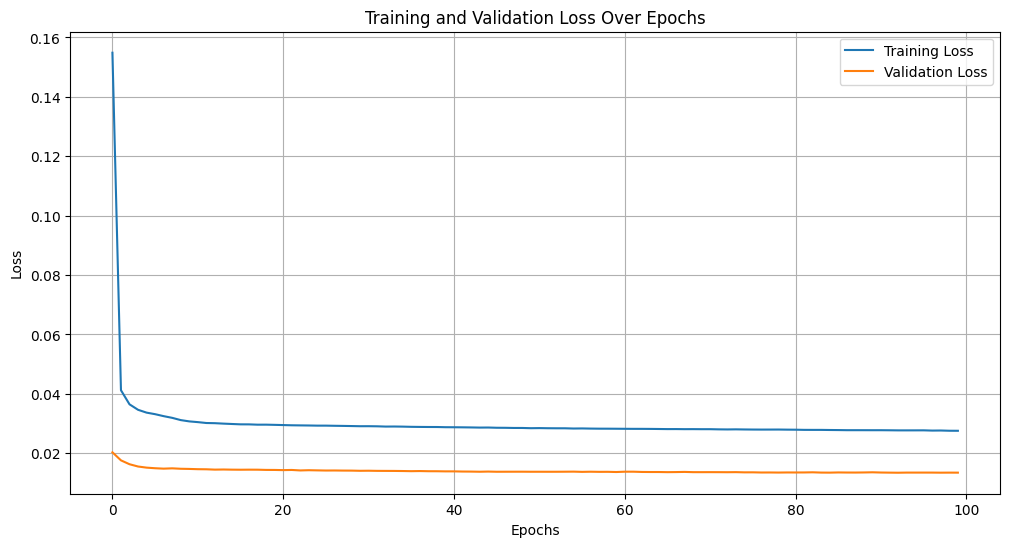

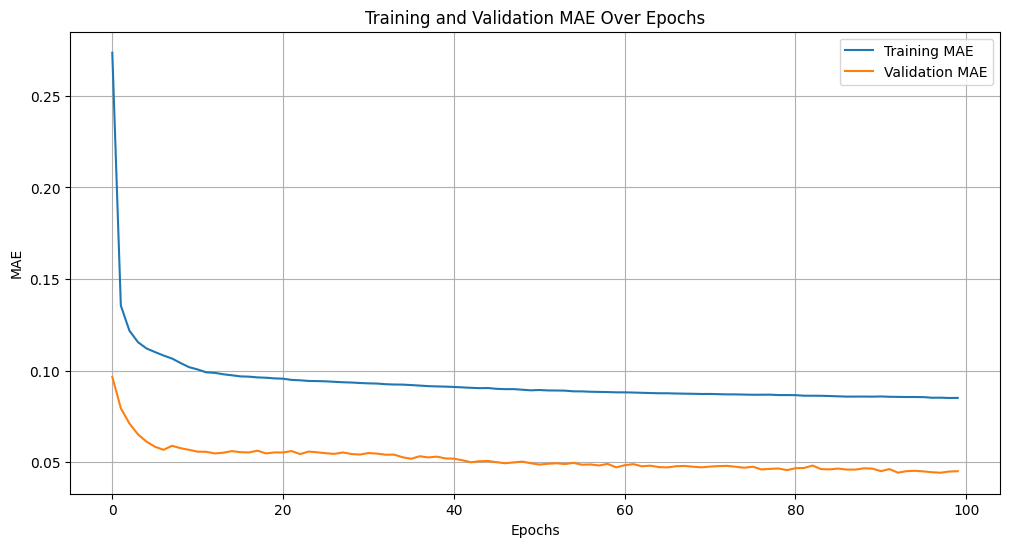

In [136]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model and store the history
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation MAE if available
if 'mae' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Training and Validation MAE Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [138]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0228 - mae: 0.0714
Test Loss: 0.03107728809118271
Test MAE: 0.09433463215827942


In [139]:
an_test_loss, an_test_mae = model.evaluate(X_silent, y_silent)

print(f"Test Loss on silent dataset: {an_test_loss}")
print(f"Test MAE on silent dataset: {an_test_mae}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0913 - mae: 0.2395
Test Loss on silent dataset: 0.09054451435804367
Test MAE on silent dataset: 0.2383907437324524


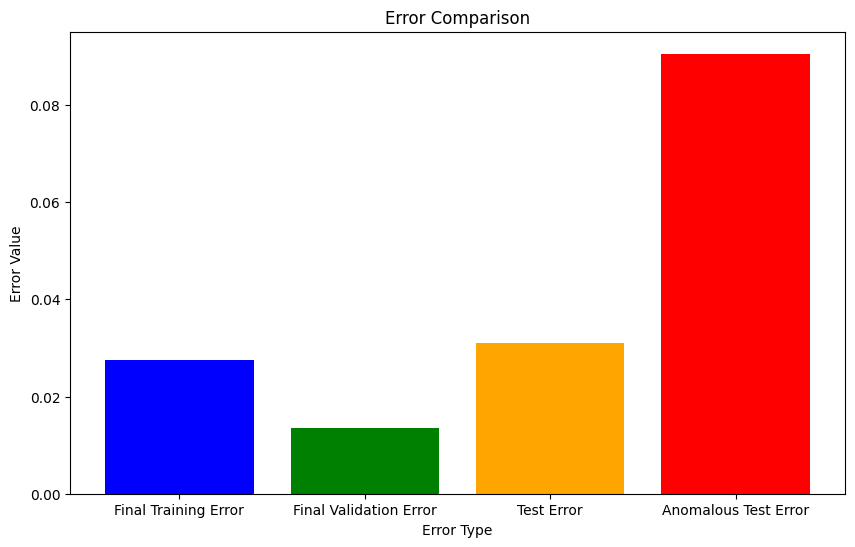

In [140]:
# Example error values (replace these with your actual error values)
final_training_error = history.history['loss'][-1]
final_validation_error = history.history['val_loss'][-1]
test_error = test_loss
anomalous_test_error = an_test_loss

# Labels and values
labels = ['Final Training Error', 'Final Validation Error', 'Test Error', 'Anomalous Test Error']
values = [final_training_error, final_validation_error, test_error, anomalous_test_error]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'green', 'orange', 'red'])

# Add labels and title
plt.xlabel('Error Type')
plt.ylabel('Error Value')
plt.title('Error Comparison')

# Show the plot
plt.show()